# Recurrent Neural Networks (RNN)

## 1.	Introduction


### Text mining and NLP problems (IMDB reviews dataset)

-	This project will explore and analyze the information stored in a particular dataset. In this case the IMDB reviews dataset (https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). We will explore different RNN models.

This project will deliver three different tasks:
1. Implement the selected model.
2. Tuning the presented models and describing how and why the results get improvement.
3. Compare the final model with one other RNN model. 
 

In [30]:
# Define all and only used package imports below
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

#!pip install opendatasets
import opendatasets as od #load kaggle datasets

# !pip install nltk
from nltk.corpus import stopwords # calculation of stopwords
import nltk
nltk.download('stopwords')

# to create the wordcloud
# !pip install wordcloud 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import requests
from io import BytesIO


# Libraries needed for modeling
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM
from keras.layers import GRU

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alext\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2.	ELT

### Extract, Load and Transform of data.



- Data should be retrieved from an online source, NOT from your local drive, otherwise, nobody can run your code without additional effort.
- Check the following link on how to retrieve data from kaggle https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook/

In [31]:
# Download data from kaggle
od.download("https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

# Read the downloaded file
data = pd.read_csv('.\imdb-dataset-of-50k-movie-reviews\IMDB Dataset.csv')

Skipping, found downloaded files in ".\imdb-dataset-of-50k-movie-reviews" (use force=True to force download)


### Report the essential description of data.
-	Don’t print out dozens of raw lines.

In [32]:
# Number of words
data['word_count'] = data['review'].apply(lambda x: len(str(x).split(" ")))
data[['review','word_count']]

#Number of characters
data['char_count'] = data['review'].str.len() ## this also includes spaces
data[['review','char_count']]

# Average word length
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

data['avg_word'] = data['review'].apply(lambda x: avg_word(x))

# Number of stop words 
stop = stopwords.words('english')
data['stopwords'] = data['review'].apply(lambda x: len([x for x in x.split() if x in stop]))

# Number of Uppercase words
data['upper'] = data['review'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

# Descriptive statistics of the DataFrame
data.describe().transpose()

count         mean         std        min         25%  \
word_count  50000.0   231.145940  171.326419   4.000000  126.000000   
char_count  50000.0  1309.431020  989.728014  32.000000  699.000000   
avg_word    50000.0     4.640676    0.340731   1.239865    4.417904   
stopwords   50000.0    94.768780   71.682687   0.000000   51.000000   
upper       50000.0     4.857800    5.627519   0.000000    1.000000   

                   50%          75%           max  
word_count  173.000000   280.000000   2470.000000  
char_count  970.000000  1590.250000  13704.000000  
avg_word      4.627006     4.847458     12.290909  
stopwords    72.000000   115.000000   1004.000000  
upper         3.000000     6.000000    162.000000

In [33]:
text = " ".join(review for review in data.review.astype(str))
print ("There are {} words in the combination of all cells in column review.".format(len(text)))
stopwords = set(STOPWORDS)

# to exclude certain words
stopwords.update(["a", "about", "above", "after", "again", "against", "all", 'also' "am", "an", "and", "any", "are",
             "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", 
             "by", 'can', "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", 
             "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", 
             "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", 
             "most", "my", "myself", 'no', 'not', "nor", "of", "on", "once", "only", "or", "other", "ought", "our", 
             "ours", "ourselves", "out", "over", "own", 's', "same", "she", "she'd", "she'll", "she's", "should",
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", 
             "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", 
             "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", 
             "we'll", "we're", "we've", "were", 'will', "what", "what's", "when", "when's", "where", "where's", 
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", 
             "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "br", "one", "want", "come", "gets","without", 'rather', "although", "will", "see", "even","make", "seem"])


There are 65521550 words in the combination of all cells in column review.


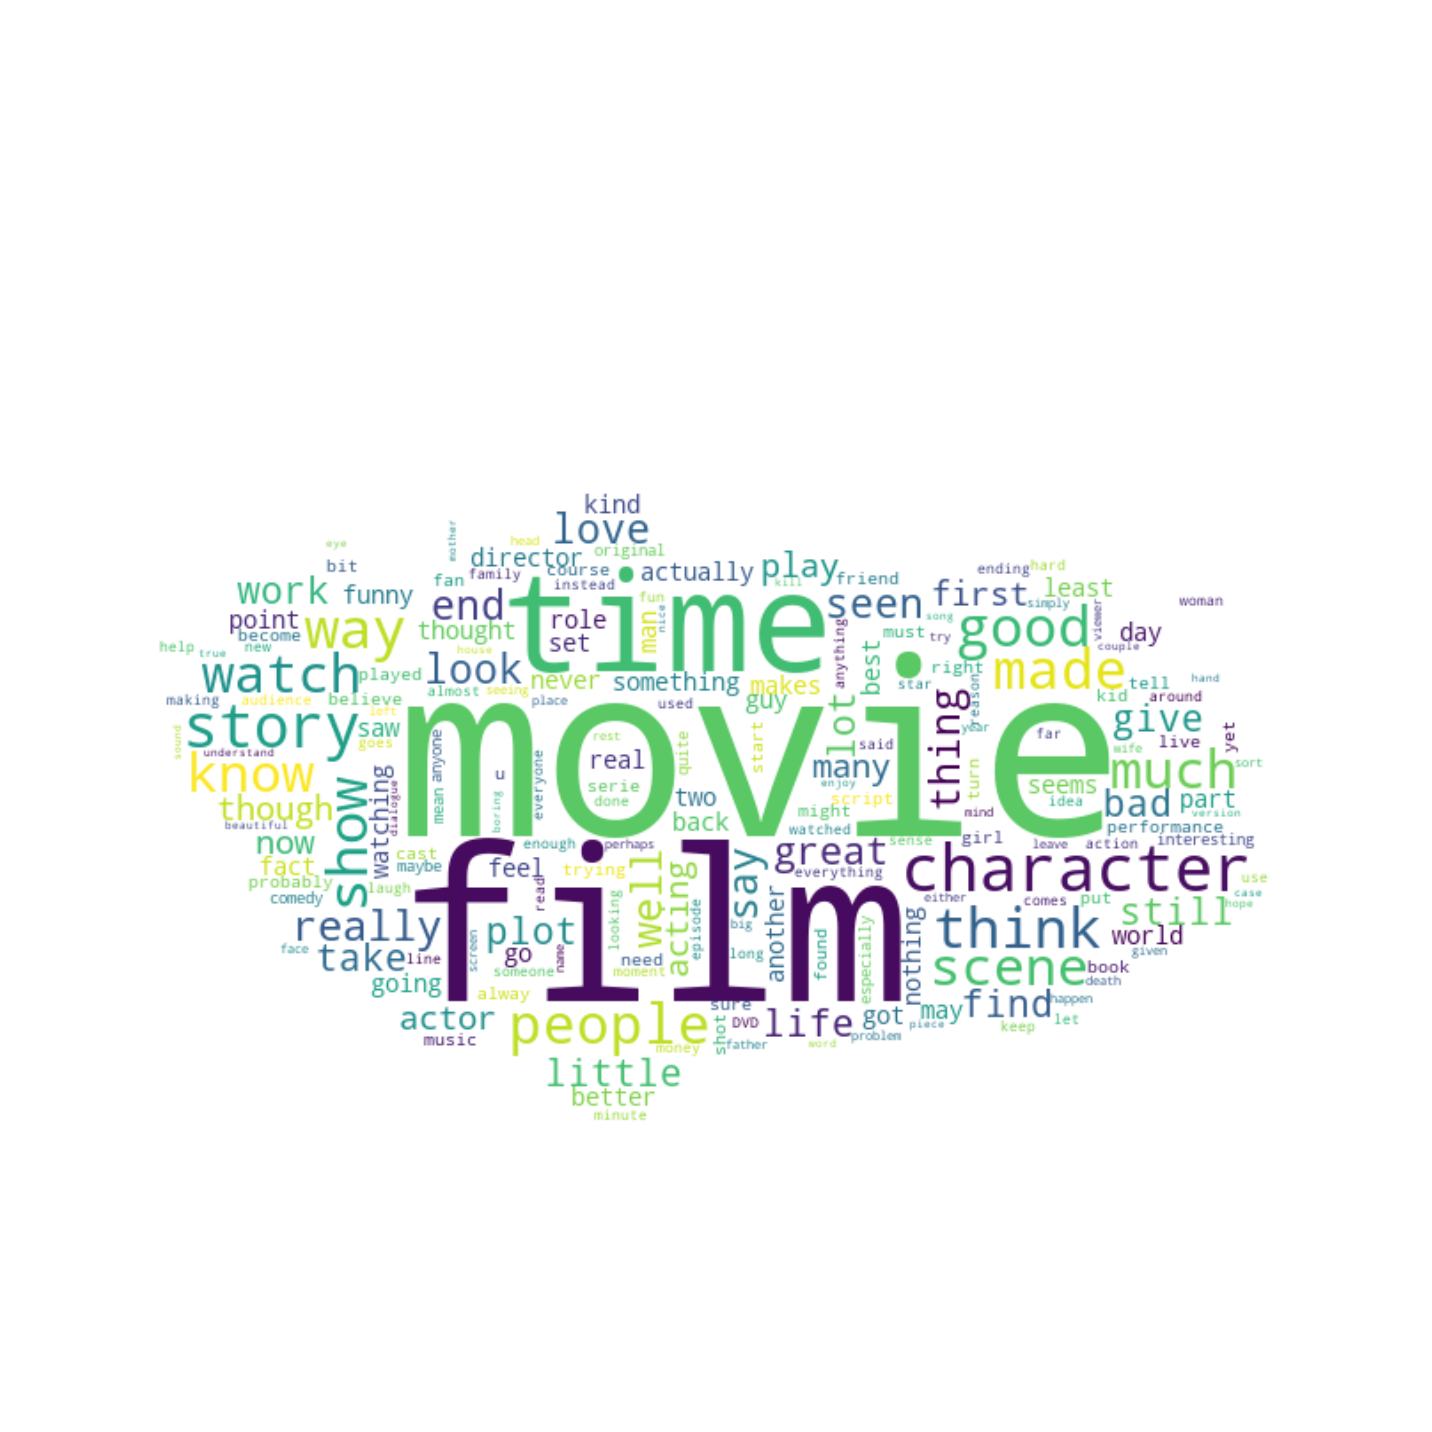

In [34]:
# Generate a word cloud image
url = "https://thumbs.dreamstime.com/b/black-cloud-smoke-isolated-over-white-background-shape-illustration-102945454.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

mask = np.array(img)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=400, height=200, mask=mask).generate(text)

# Display the generated image:
# the matplotlib way:

plt.figure( figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.show()

## 3.	Modeling

### Prepare analytics here and construct all the data objects you will use in your report.
•	Write functions and classes to simplify tasks. Do not repeat yourself.

•	Avoid output.

•	Refactor your code until it’s clean

In [35]:
# Split text and label to train/validation
texts = data["review"]
labels = data["sentiment"]

training_portion = .8
train_size = int(len(texts) * training_portion)

train_texts = texts[:train_size]
train_labels = labels[:train_size]

validation_texts = texts[train_size:]
validation_labels = labels[train_size:]

# print(train_size)
# print(len(train_texts))
# print(len(train_labels))
# print(len(validation_texts))
# print(len(validation_labels))

In [36]:
vocab_size = 1000 
embedding_dim = 16
max_length =  128 
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'


tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_texts)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)


# print(len(train_sequences[0]))
# print(len(train_padded[0]))

# print(len(train_sequences[1]))
# print(len(train_padded[1]))

# print(len(train_sequences[10]))
# print(len(train_padded[10]))

In [37]:
validation_sequences = tokenizer.texts_to_sequences(validation_texts)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

# print(len(validation_sequences))
# print(validation_padded.shape)

In [38]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

# print(training_label_seq[0])
# print(training_label_seq[1])
# print(training_label_seq[2])
# print(training_label_seq.shape)

# print(validation_label_seq[0])
# print(validation_label_seq[1])
# print(validation_label_seq[2])
# print(validation_label_seq.shape)

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(12, activation='selu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
# model.summary()

In [40]:
num_epochs = 10
history = model.fit(train_padded, 
                    training_label_seq, 
                    epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq), 
                    verbose=2)

Epoch 1/10
1250/1250 - 4s - loss: 0.6405 - accuracy: 0.7199 - val_loss: 0.4139 - val_accuracy: 0.8270
Epoch 2/10
1250/1250 - 2s - loss: 0.3749 - accuracy: 0.8375 - val_loss: 0.3596 - val_accuracy: 0.8397
Epoch 3/10
1250/1250 - 2s - loss: 0.3487 - accuracy: 0.8473 - val_loss: 0.3513 - val_accuracy: 0.8445
Epoch 4/10
1250/1250 - 2s - loss: 0.3418 - accuracy: 0.8521 - val_loss: 0.3511 - val_accuracy: 0.8424
Epoch 5/10
1250/1250 - 2s - loss: 0.3400 - accuracy: 0.8522 - val_loss: 0.3499 - val_accuracy: 0.8426
Epoch 6/10
1250/1250 - 2s - loss: 0.3384 - accuracy: 0.8524 - val_loss: 0.3508 - val_accuracy: 0.8431
Epoch 7/10
1250/1250 - 2s - loss: 0.3370 - accuracy: 0.8541 - val_loss: 0.3508 - val_accuracy: 0.8428
Epoch 8/10
1250/1250 - 2s - loss: 0.3371 - accuracy: 0.8532 - val_loss: 0.3530 - val_accuracy: 0.8429
Epoch 9/10
1250/1250 - 2s - loss: 0.3363 - accuracy: 0.8533 - val_loss: 0.3522 - val_accuracy: 0.8432
Epoch 10/10
1250/1250 - 2s - loss: 0.3366 - accuracy: 0.8532 - val_loss: 0.3521 - 

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(LSTM(64)),
    tf.keras.layers.Dense(12, activation='selu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
# model.summary()


history = model.fit(train_padded, 
                    training_label_seq, 
                    epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq))

Epoch 1/10
1250/1250 [==============================] - 250s 196ms/step - loss: 0.5618 - accuracy: 0.6827 - val_loss: 0.3901 - val_accuracy: 0.8206
Epoch 2/10
1250/1250 [==============================] - 239s 191ms/step - loss: 0.3832 - accuracy: 0.8321 - val_loss: 0.3736 - val_accuracy: 0.8349
Epoch 3/10
1250/1250 [==============================] - 230s 184ms/step - loss: 0.3538 - accuracy: 0.8471 - val_loss: 0.3416 - val_accuracy: 0.8504
Epoch 4/10
1250/1250 [==============================] - 229s 183ms/step - loss: 0.3309 - accuracy: 0.8575 - val_loss: 0.3300 - val_accuracy: 0.8558
Epoch 5/10
1250/1250 [==============================] - 230s 184ms/step - loss: 0.3150 - accuracy: 0.8627 - val_loss: 0.3246 - val_accuracy: 0.8541
Epoch 6/10
1250/1250 [==============================] - 229s 183ms/step - loss: 0.3031 - accuracy: 0.8712 - val_loss: 0.3221 - val_accuracy: 0.8626
Epoch 7/10
1250/1250 [==============================] - 229s 183ms/step - loss: 0.2936 - accuracy: 0.8753 - val_

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(GRU(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(GRU(64)),
    tf.keras.layers.Dense(12, activation='selu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
# model.summary()


history = model.fit(train_padded, 
                    training_label_seq, 
                    epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq))

Epoch 1/10
1250/1250 [==============================] - 210s 164ms/step - loss: 0.4712 - accuracy: 0.7580 - val_loss: 0.3615 - val_accuracy: 0.8365
Epoch 2/10
1250/1250 [==============================] - 198s 159ms/step - loss: 0.3337 - accuracy: 0.8553 - val_loss: 0.3188 - val_accuracy: 0.8556
Epoch 3/10
1250/1250 [==============================] - 195s 156ms/step - loss: 0.3028 - accuracy: 0.8697 - val_loss: 0.3208 - val_accuracy: 0.8631
Epoch 4/10
1250/1250 [==============================] - 196s 157ms/step - loss: 0.2863 - accuracy: 0.8796 - val_loss: 0.3111 - val_accuracy: 0.8642
Epoch 5/10
1250/1250 [==============================] - 195s 156ms/step - loss: 0.2741 - accuracy: 0.8841 - val_loss: 0.3110 - val_accuracy: 0.8669
Epoch 6/10
1250/1250 [==============================] - 195s 156ms/step - loss: 0.2658 - accuracy: 0.8882 - val_loss: 0.3134 - val_accuracy: 0.8667
Epoch 7/10
1250/1250 [==============================] - 195s 156ms/step - loss: 0.2567 - accuracy: 0.8929 - val_

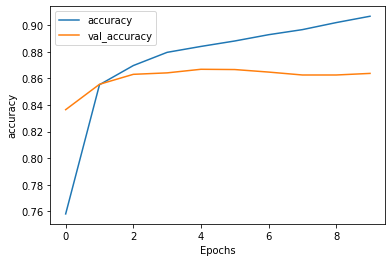

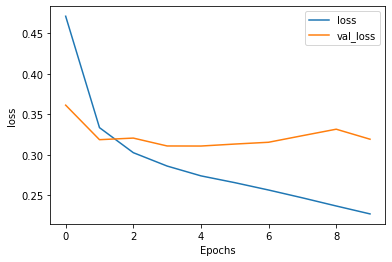

In [43]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## 4.	Results

•	Print out relevant tables nicely, display well-annotated charts and explain if needed in plain English.
•	Use minimum code here, just output-functions’ calls.

## 5.	Conclusions

•	Summarize your findings here in 5...10 lines of text.

In [44]:
#! git clone https://github.com/AlexTouvras/FindingSimilarItems

In [45]:
#! git add -A

In [46]:
#! git commit -am "dataset and initial descriptive statistics" 
#! git push 